In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import datetime

In [31]:
# loading the csv data to a Pandas DataFrame
gold_data = pd.read_csv('goldstock.csv')

In [32]:
# print first 5 rows in the dataframe
gold_data.head()

,Unnamed: 0,Date,Close,Volume,Open,High,Low
0,0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1


In [33]:
# Convert 'Date' column to datetime format
gold_data['Date'] = pd.to_datetime(gold_data['Date'])

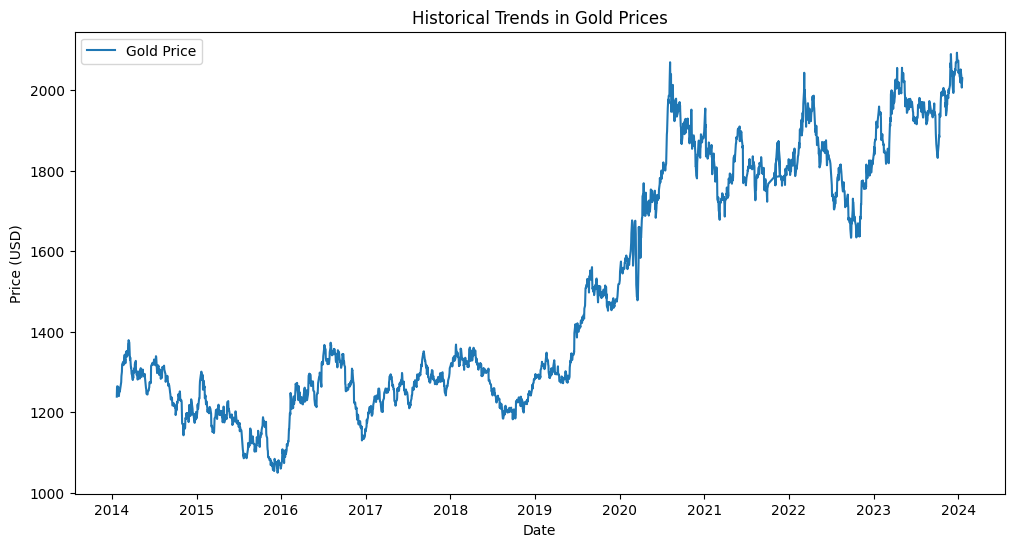

In [34]:
# Time Series Analysis
# Plotting historical trends
plt.figure(figsize=(12, 6))
plt.plot(gold_data['Date'], gold_data['Close'], label='Gold Price')
plt.title('Historical Trends in Gold Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [35]:
# Decomposition
decomposition = seasonal_decompose(gold_data['Close'], model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


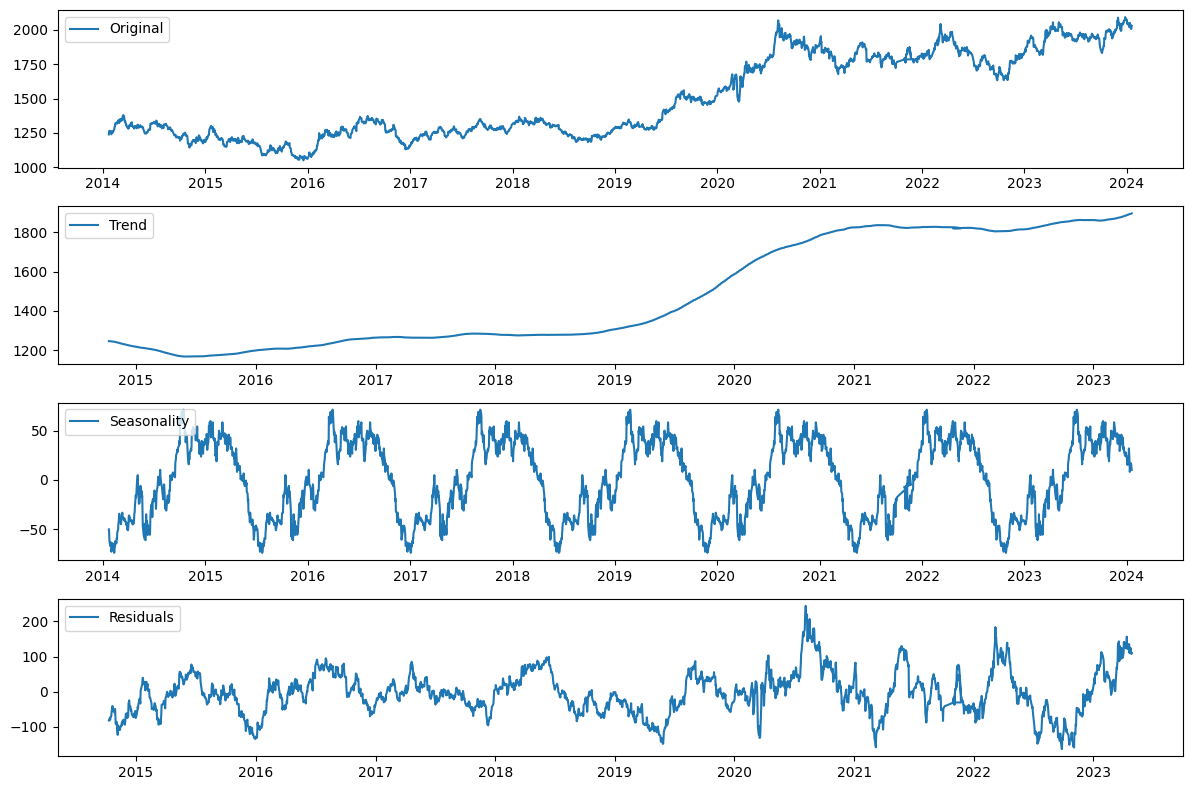

In [36]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(gold_data['Date'], gold_data['Close'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(gold_data['Date'], trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(gold_data['Date'], seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(gold_data['Date'], residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()


In [37]:
# Stationarity Test
result = adfuller(gold_data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -1.7172755789704783
p-value: 0.4222342775667278
Critical Values: {'1%': -3.4329579682301254, '5%': -2.8626921885291017, '10%': -2.5673833542324727}


In [38]:
correlation = gold_data.corr()

<Axes: >

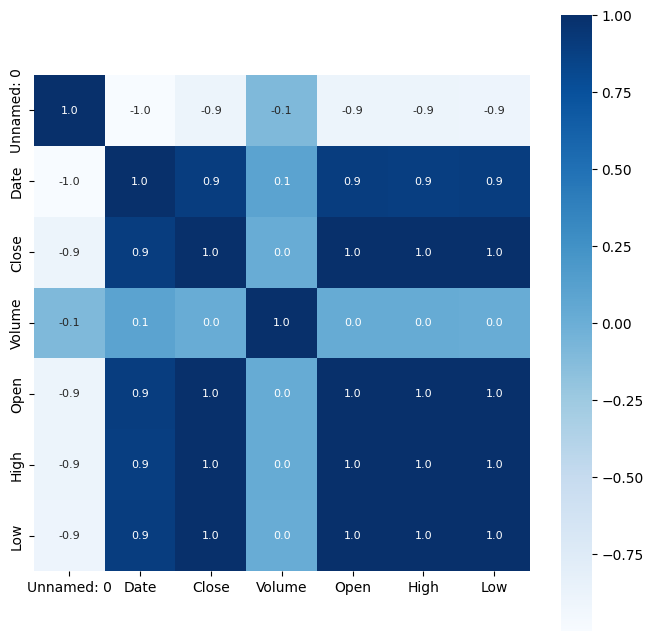

In [39]:
# constructing a heatmap to understand the correlatiom
plt.figure(figsize = (8,8))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f',annot=True, annot_kws={'size':8}, cmap='Blues')

In [40]:
# Advanced Modeling
# SARIMA Model
train_size = int(len(gold_data) * 0.8)
train, test = gold_data[:train_size]['Close'], gold_data[train_size:]['Close']

In [41]:
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

In [42]:
# Forecasting
sarima_predictions = model_fit.forecast(steps=len(test))

In [43]:
# Model Evaluation
mae = mean_absolute_error(test, sarima_predictions)
mse = mean_squared_error(test, sarima_predictions)
print('Mean Absolute Error for sarima:', mae)
print('Mean Squared Error for sarima:', mse)


Mean Absolute Error for sarima: 230.06399750106905
Mean Squared Error for sarima: 72109.0831025811


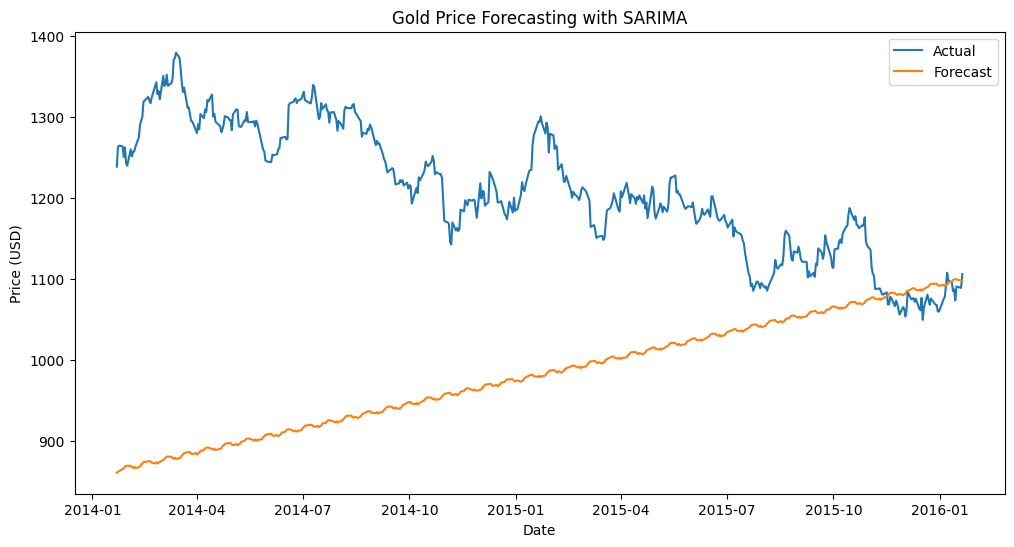

In [44]:
# Plotting Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(gold_data['Date'][train_size:], test, label='Actual')
plt.plot(gold_data['Date'][train_size:], sarima_predictions, label='Forecast')
plt.title('Gold Price Forecasting with SARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [45]:
# Trading Strategy Development
# Moving Average Strategy
gold_data['SMA_50'] = gold_data['Close'].rolling(window=50).mean()
gold_data['SMA_200'] = gold_data['Close'].rolling(window=200).mean()

In [46]:
# Buy when SMA_50 crosses above SMA_200, Sell when SMA_50 crosses below SMA_200
gold_data['Position'] = np.where(gold_data['SMA_50'] > gold_data['SMA_200'], 1, -1)

In [47]:
# Backtesting
gold_data['Profit'] = gold_data['Position'].shift(1) * gold_data['Close'].pct_change()
cumulative_profit = (gold_data['Profit'] + 1).cumprod()


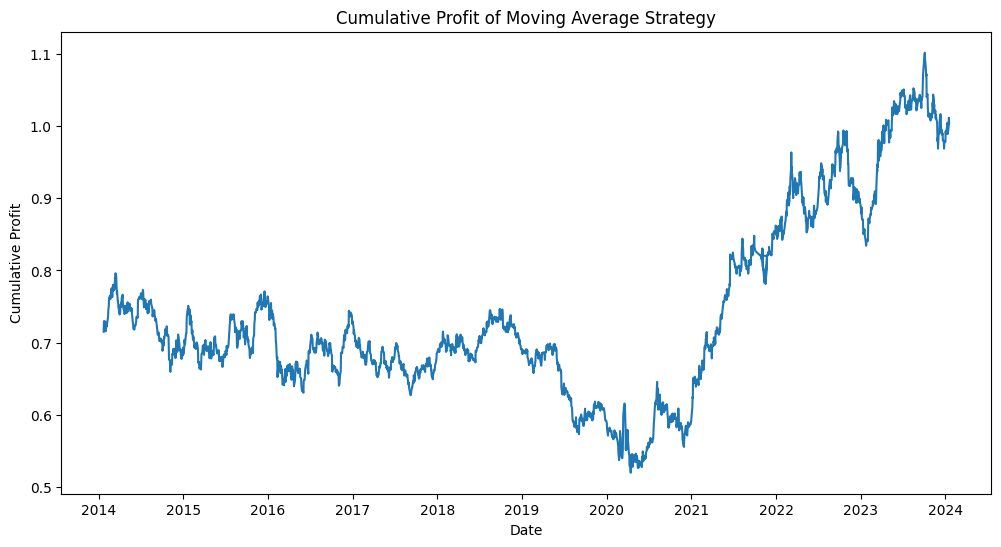

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(gold_data['Date'], cumulative_profit)
plt.title('Cumulative Profit of Moving Average Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit')
plt.show()

In [49]:
# Feature Engineering
gold_data['Year'] = gold_data['Date'].dt.year
gold_data['Month'] = gold_data['Date'].dt.month
gold_data['Day'] = gold_data['Date'].dt.day

In [50]:
# Splitting into train and test sets
train_size = int(len(gold_data) * 0.8)
train, test = gold_data[:train_size], gold_data[train_size:]

In [51]:
# Selecting features and target variable
features = ['Year', 'Month', 'Day']
target = 'Close'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

In [53]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [54]:
# Predictions
rf_predictions = rf_model.predict(X_test)

In [56]:
# Model Evaluation
mae = mean_absolute_error(y_test, rf_predictions)
mse = mean_squared_error(y_test, rf_predictions)
print('Mean Absolute Error for random forest:', mae)
print('Mean Squared Error for random forest:', mse)

Mean Absolute Error for random forest: 88.10700596421452
Mean Squared Error for random forest: 11938.371587661983


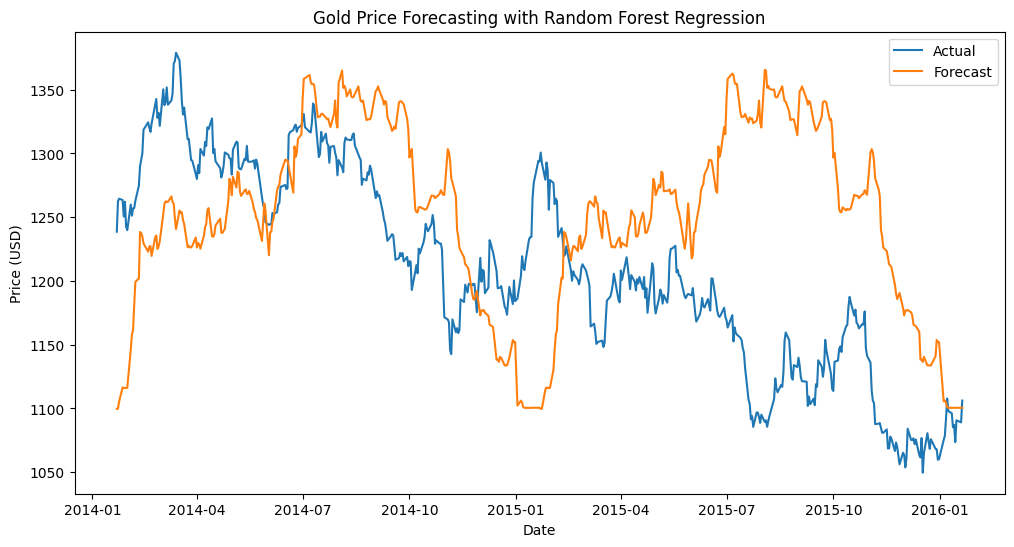

In [58]:
# Plotting Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], y_test, label='Actual')
plt.plot(test['Date'], rf_predictions, label='Forecast')
plt.title('Gold Price Forecasting with Random Forest Regression')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [59]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [60]:
# Feature Engineering
gold_data['Year'] = gold_data['Date'].dt.year
gold_data['Month'] = gold_data['Date'].dt.month
gold_data['Day'] = gold_data['Date'].dt.day


In [62]:
# Splitting into train and test sets
from sklearn.model_selection import train_test_split


X = gold_data[['Year', 'Month', 'Day']]
y = gold_data['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [63]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest Regression': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(n_estimators=100, random_state=42)
}


In [64]:
# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    results[name] = {'MAE': mae, 'MSE': mse}

In [65]:
# Print results
for name, result in results.items():
    print(f'{name}: MAE={result["MAE"]}, MSE={result["MSE"]}')


Linear Regression: MAE=109.74531221693096, MSE=18375.20886632134
Ridge Regression: MAE=109.74649283641716, MSE=18374.98816482178
Lasso Regression: MAE=109.74658087836931, MSE=18364.16930449534
Random Forest Regression: MAE=11.802966202783427, MSE=270.89688108946626
Gradient Boosting Regression: MAE=35.780235045755354, MSE=2263.3611282235406


In [66]:
# Select the best performing model
best_model_name = min(results, key=lambda x: results[x]['MAE'])
best_model = models[best_model_name]


In [67]:
# Print the best performing model
print(f'\nBest performing model: {best_model_name}')


Best performing model: Random Forest Regression


In [68]:
# Train the final model on the full dataset
final_model = best_model.fit(X, y)

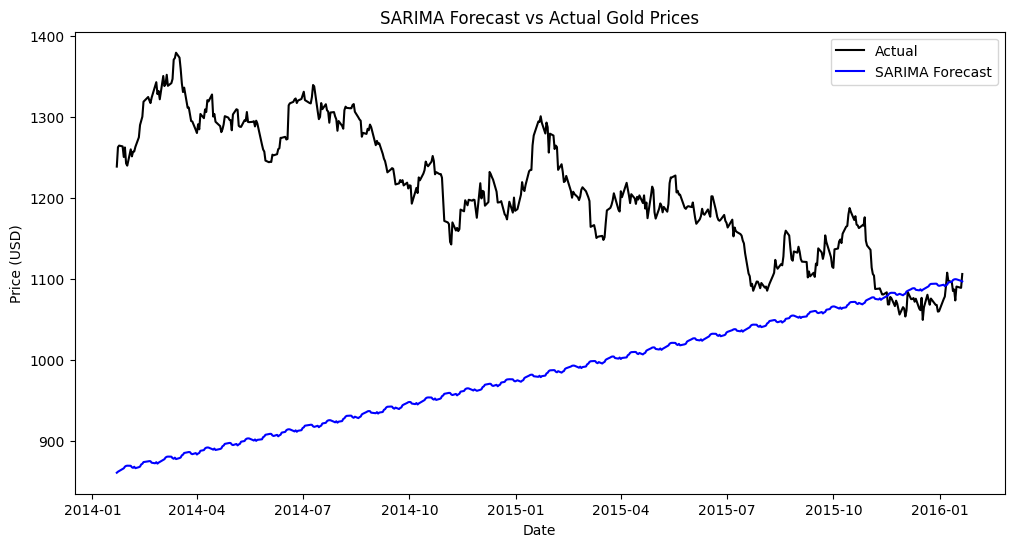

In [69]:
# SARIMA Forecast vs Actual Plot
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['Close'], label='Actual', color='black')
plt.plot(test['Date'], sarima_predictions, label='SARIMA Forecast', color='blue')
plt.title('SARIMA Forecast vs Actual Gold Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

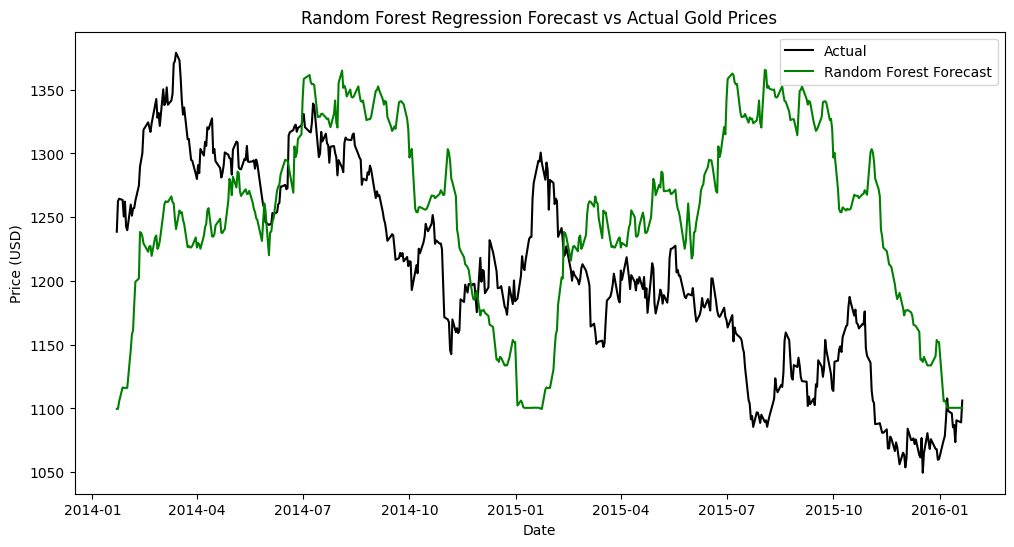

In [70]:

# Random Forest Regression Forecast vs Actual Plot
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['Close'], label='Actual', color='black')
plt.plot(test['Date'], rf_predictions, label='Random Forest Forecast', color='green')
plt.title('Random Forest Regression Forecast vs Actual Gold Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [71]:
# Initialize models
models = {
    'SARIMA': SARIMAX(train['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)),
    'Random Forest Regression': RandomForestRegressor(n_estimators=100, random_state=42)
}



In [72]:
# Train and evaluate models
results = {}
for name, model in models.items():
    if name == 'SARIMA':
        model_fit = model.fit(disp=False)
        predictions = model_fit.forecast(steps=len(test))
    else:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
    mae = mean_absolute_error(test['Close'], predictions)
    mse = mean_squared_error(test['Close'], predictions)
    results[name] = {'MAE': mae, 'MSE': mse}




In [73]:
# Print results
for name, result in results.items():
    print(f'{name}: MAE={result["MAE"]}, MSE={result["MSE"]}')


SARIMA: MAE=230.06399750106905, MSE=72109.0831025811
Random Forest Regression: MAE=300.3193876739562, MSE=169357.068243316


In [74]:

# Select the best performing model
best_model_name = min(results, key=lambda x: results[x]['MAE'])
best_model = models[best_model_name]


In [75]:

print(f'\nBest performing model: {best_model_name}')



Best performing model: SARIMA


In [76]:
final_model = SARIMAX(train['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
final_model_fit = final_model.fit(disp=False)


In [77]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib


joblib.dump(final_model_fit, 'sarima_model.pkl')

['sarima_model.pkl']